## 0. 사용할 라이브러리 불러오기

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import glob
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Step 1. 데이터 읽어오기
---
txt 파일로 저장되어 있는 가사들이 담긴 폴더를 불러온다. 이때 glob을 활용하여 한번에 txt 파일들을 불러 올 수 있다.  
 

In [3]:

txt_file_path = '/content/drive/MyDrive/COLAB_data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담기
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Build your dreams to the stars above', 'But when you need someone to love', "Don't go to strangers, darling, come to me Play with fire till your fingers burn"]


raw_corpus의 크기가 187,088개로 187,088 개의 가사줄이 입력되어 있는 것을 확인할 수 있다.  


- 참고 :splitlines()은 줄단위로 문자열을 리스트화 하는 함수 [splitlines()관련](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=debolm74&logNo=221953881991)


### Step 2. 데이터 정제
---
`preprocess_sentence()` 함수를 활용해 데이터를 정제하기.  

추가로 너무 긴 문장은 과도한 padding을 생성하므로 제거하기로 한다.  
너무 긴 문장은 노래 작사에도 어울리지 않는다고 한다.   

-> 이번엔 문장을 토큰화 했을 때 **토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외**해보자. 

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) 
    sentence = sentence.strip() 
    sentence = '<start> ' + sentence + ' <end>' 
    return sentence

In [ ]:
#잘 작동하는지 확인하기
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [ ]:
# 정제된 문장을 담을 곳
corpus = []

for sentence in raw_corpus:
    # 혹시 길이가 0인 문장이 있을 수 있으니 길이 0인 문장은 제외하자
    if len(sentence) == 0: continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:15]

['<start> build your dreams to the stars above <end>',
 '<start> but when you need someone to love <end>',
 '<start> don t go to strangers , darling , come to me play with fire till your fingers burn <end>',
 '<start> and when there s no place for you to turn <end>',
 '<start> don t go to strangers , darling , come to me for , when you hear a call to follow your heart <end>',
 '<start> you ll follow your heart i know <end>',
 '<start> i ve been through it all , for i m an old hand <end>',
 '<start> and i ll understand if you go so <end>',
 '<start> make your mark for your friends to see <end>',
 '<start> but when you need more than company <end>',
 '<start> don t go to strangers , darling , come to me tonight you re mine , completely <end>',
 '<start> you give your soul so sweetly <end>',
 '<start> tonight the light of love is in your eyes <end>',
 '<start> will you love me tomorrow is this a lasting treasure <end>',
 '<start> or just a moment s pleasure <end>']

정제된 결과를 보니,  
- he s, i d don t 같이 '가 빠져 단어의 의미가 이상하게 출력되는 것들이 보인다. 나는 단어별로 의미를 넣어 공부하게 시키고 싶기 때문에 [']는 제거하지 않기로 한다. 

`preprocess_sentence()`를 수정해 본다.  

※ 근데 생각해보면 '를 포함하면 she is 와 she's 는 she라는 같은 단어의 변형인데 아예 다르게 보니까 she에 대한 학습이 덜 될 것 같다.  
-> 이 상태로 한번 돌려보고 이후 뒤에 원래 함수로 다시 돌려봐야겠다.

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-zA-Z?.!,¿']+", " ", sentence) 
    sentence = sentence.strip() 
    sentence = '<start> ' + sentence + ' <end>' 
    return sentence

In [ ]:
# 정제된 문장을 담을 곳
corpus = []

for sentence in raw_corpus:
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)

    if preprocessed_sentence.count(' ') >= 14: continue

    corpus.append(preprocessed_sentence)

# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> build your dreams to the stars above <end>',
 '<start> but when you need someone to love <end>',
 "<start> and when there's no place for you to turn <end>",
 "<start> you'll follow your heart i know <end>",
 "<start> i've been through it all , for i'm an old hand <end>",
 "<start> and i'll understand if you go so <end>",
 '<start> make your mark for your friends to see <end>',
 '<start> but when you need more than company <end>',
 '<start> you give your soul so sweetly <end>',
 '<start> tonight the light of love is in your eyes <end>']

깔끔한 데이터를 얻어낸 것 같다!  

※ 단어의 갯수는 빈칸의 갯수보다 1개 더 많으니까 ' '의 수를 14 이상으로 조절하였다.   

이제 tokenize를 진행해보자!

### Step 3. 평가 데이터셋 분리
---
훈련 데이터와 평가 데이터를 분리하기  

    1) tokenize() 함수로 데이터를 Tensor로 변환  
    2) sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리    
    3) 단어장의 크기는 12,000 이상으로 설정  
    4) 총 데이터의 20% 를 평가 데이터셋으로 사용  


- 단어장의 크기는 미국인 20세의 평균 단어 수가 약 42,000개라고 하니 42,000을 넣어보자

In [7]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=42000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)

    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[    2  1423    17 ...     0     0     0]
 [    2    31    41 ...     0     0     0]
 [    2     8    41 ...     0     0     0]
 ...
 [    2    28    17 ...     4 18184     3]
 [    2   351    17 ...   159     3     0]
 [    2    37   131 ...     0     0     0]] <keras_preprocessing.text.Tokenizer object at 0x7f88df3ecf50>


In [ ]:
#tokenizer에 단어 사전이 어떻게 구축되었는지 한번 보자
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : the
6 : i
7 : you
8 : and
9 : a
10 : to


단어장은 `fit_on_texts()`를 사용하여, 그 ()안에 들어간 문장들의 빈도수에 따라 숫자를 메긴다고 한다.  
신기하군...

In [ ]:
#생성된 텐서 데이터를 3번째 행, 15번째 열까지만 출력해보기(15이상은 짤랐으니까)
print(tensor[:3, :15])

[[   2 1423   17  378   10    5  628  684    3    0    0    0    0    0]
 [   2   31   41    7   87  341   10   33    3    0    0    0    0    0]
 [   2    8   41  167   36  248   26    7   10  200    3    0    0    0]]


역시나 첫번째가 `<start>`로 고정되어 있어 처음 숫자가 2이고,  
마지막이 `<end>`라 끝이 3이고 나머지는 padding으로 0인것을 확인했다.  

이제 준비한 데이터들은 전처리를 마쳤으니, train 과 test 자료로 나눠서 입력해보도록 하자.

In [ ]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
X = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
y = tensor[:, 1:]    

print(X[0])
print(y[0])

[   2 1423   17  378   10    5  628  684    3    0    0    0    0]
[1423   17  378   10    5  628  684    3    0    0    0    0    0]


In [ ]:
#trainning 데이터와 validation 데이터로 분리하기

enc_train, enc_val, dec_train, dec_val = train_test_split(X, y, test_size=0.2, random_state=50)

#잘 나눠졌는지 확인
print(enc_train.shape, dec_train.shape)
print(enc_val.shape, dec_val.shape)

(131640, 13) (131640, 13)
(32910, 13) (32910, 13)


토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 삭제하고,  
x, y로 나눌때 한 칸씩 지웠으니 단어의 길이가 13개가 되어 데이터의 모양이 (n, 13)이 되는 것을 확인했다.

In [ ]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 42,000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋 만들기
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) 
#drop_remainder= batch size에 도달하면 나머지 데이터는 버림 
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 13), dtype=tf.int32, name=None), TensorSpec(shape=(256, 13), dtype=tf.int32, name=None))>

### Step 4. 인공지능 만들기
---
모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 **val_loss 값을 2.2 수준**으로 줄일 수 있는 모델을 설계해보기   

우선 Embedding Size와 Hidden Size는 이론시 진행했던 사이즈를 넣어 돌려본 후 수정해보도록 하자.


In [19]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

이제 데이터셋의 1배치만 불러와서 컴퓨터에게 사이즈를 알려줍시다.

In [ ]:
for src_enc_train, dec_train in dataset.take(1): break

model(src_enc_train)

<tf.Tensor: shape=(256, 13, 42001), dtype=float32, numpy=
array([[[ 6.02146283e-05, -9.25729910e-05,  9.05130801e-05, ...,
          5.15796601e-05, -2.49478635e-05, -1.04455299e-04],
        [-1.56203227e-04, -2.40075664e-04,  2.02799492e-04, ...,
          1.08062886e-04, -1.73312277e-04, -8.60768996e-05],
        [-2.13231076e-04, -3.93638416e-04,  2.73368671e-04, ...,
          5.83318215e-05, -1.75069421e-04, -1.31604029e-04],
        ...,
        [ 2.23257623e-04,  1.73658424e-04,  4.70407977e-05, ...,
         -2.82316556e-04, -4.16342518e-05, -1.34513766e-05],
        [ 2.74100661e-04,  1.17327712e-04,  1.62154378e-04, ...,
         -4.64242243e-04, -4.19122807e-05, -6.22044172e-05],
        [ 2.33111059e-04, -1.42285817e-05,  3.58206365e-04, ...,
         -5.90870855e-04, -1.08271728e-04, -1.70958549e-04]],

       [[ 6.02146283e-05, -9.25729910e-05,  9.05130801e-05, ...,
          5.15796601e-05, -2.49478635e-05, -1.04455299e-04],
        [ 3.67005632e-05, -1.47057406e-04,  1

배치만 넣어보니 tf.Tensor의 shape이 (256, 13, 42001)로,  
제시한 embedding 사이즈 256, 토큰의 갯수 13, 글자 수+0 42001으로 알맞게 변형된 것을 확인할 수 있습니다.  

이제 사이즈를 알았으니 컴퓨터가 모델을 서머리할 수 있겠죠?? 확인해봅시다. 

In [ ]:
#모델 서머리!
model.summary()

Model: "text_generator_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  10752256  
                                                                 
 lstm_6 (LSTM)               multiple                  5246976   
                                                                 
 lstm_7 (LSTM)               multiple                  8392704   
                                                                 
 dense_3 (Dense)             multiple                  43051025  
                                                                 
Total params: 67,442,961
Trainable params: 67,442,961
Non-trainable params: 0
_________________________________________________________________


확실히 글자 수를 기존 7,000 -> 42,000으로 증가시켜서 그런지 토탈 파라미터값이 3배정도(22,607,961 -> 67,442,961)증가된 것을 볼 수 있다.

In [ ]:
#모델 학습시키기
optimizer = tf.keras.optimizers.Adam()
#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

Epoch 1/10
514/514 [==============================] - 109s 205ms/step - loss: 3.7202 - val_loss: 3.2335
Epoch 2/10
514/514 [==============================] - 104s 203ms/step - loss: 3.0932 - val_loss: 3.0437
Epoch 3/10
514/514 [==============================] - 104s 203ms/step - loss: 2.9079 - val_loss: 2.9369
Epoch 4/10
514/514 [==============================] - 105s 203ms/step - loss: 2.7701 - val_loss: 2.8622
Epoch 5/10
514/514 [==============================] - 104s 203ms/step - loss: 2.6477 - val_loss: 2.7988
Epoch 6/10
514/514 [==============================] - 104s 203ms/step - loss: 2.5319 - val_loss: 2.7445
Epoch 7/10
514/514 [==============================] - 104s 203ms/step - loss: 2.4219 - val_loss: 2.6959
Epoch 8/10
514/514 [==============================] - 104s 203ms/step - loss: 2.3170 - val_loss: 2.6579
Epoch 9/10
514/514 [==============================] - 104s 203ms/step - loss: 2.2200 - val_loss: 2.6237
Epoch 10/10
514/514 [==============================] - 104s 203m

학습을 시켜보니,   
train의 loss 값은 3.7 -> 2.1 까지 낮아지는 반면,   
validation의 loss 값은 3.2 ->2.6 으로 낮아져 루브릭 기준인 2.2 까지 낮아지지 않았다.  

시각화해서 한번 확인해볼까?

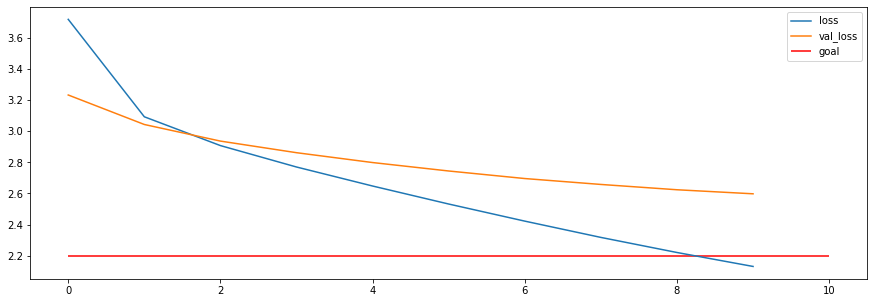

In [ ]:
#그래프 시각화
plt.figure(figsize=(15,5)) 
plt.plot(history.history['loss'], label='loss') 
plt.plot(history.history['val_loss'], label='val_loss') 
plt.hlines(2.2,0,10, color="red", label='goal')
plt.legend() 
plt.show()

시각화를 하고 보니,   
loss, val_loss 값 모두 1번의 급격한 감소 이후 완만하게 감소하는 추세를 보였으며,   
loss는 2.1까지 내려가 목표인 2.2 이하로 떨어졌지만, val_loss는 소폭 감소하며 목표인 2.2까지 떨어지지 못했다.  

하지만 그래프를 보아 과적합은 이뤄지지 않았으니 다른 부분을 조정하여 val_loss 값을 낮춰보자.

## 추후 진행 내용 
    1) 데이터 정제시 ' 제외하고 다시 학습시켜보기
    2) embedding size 증가하여 돌려보기  
    3) hidden layer 증가하여 돌려보기  
    4) 다른 변경할 수 있을만한? 것들 넣어서 돌려보기 
    추가) 길이 긴 문장 제외하지 않고 돌려보기 

상기 내용을 순차적으로 진행해보면서 과적합이 일어나지 않도록 설계해보자.

---

### 1) 데이터 정제시 ' 제외하고 다시 학습시켜보기  
- preprocess_sentence 함수 정의시 ' 까지 제외하고 데이터를 넣어보자.

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) 
    sentence = sentence.strip() 
    sentence = '<start> ' + sentence + ' <end>' 
    return sentence

In [ ]:
corpus = []

for sentence in raw_corpus:
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)

    if preprocessed_sentence.count(' ') >= 14: continue

    corpus.append(preprocessed_sentence)

# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> build your dreams to the stars above <end>',
 '<start> but when you need someone to love <end>',
 '<start> and when there s no place for you to turn <end>',
 '<start> you ll follow your heart i know <end>',
 '<start> and i ll understand if you go so <end>',
 '<start> make your mark for your friends to see <end>',
 '<start> but when you need more than company <end>',
 '<start> you give your soul so sweetly <end>',
 '<start> tonight the light of love is in your eyes <end>',
 '<start> will you love me tomorrow is this a lasting treasure <end>']

In [ ]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=42000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)

    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[    2  1386    19 ...     0     0     0]
 [    2    33    45 ...     0     0     0]
 [    2     8    45 ...     3     0     0]
 ...
 [    2    30    19 ...     5 17293     3]
 [    2   346    19 ...   159     3     0]
 [    2    41   130 ...     0     0     0]] <keras_preprocessing.text.Tokenizer object at 0x7f311883a190>


In [ ]:
#tokenizer에 단어 사전이 어떻게 구축되었는지 한번 보자
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])
    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


확실히 '로 (대부분의) 주어를 구분시켜주니 i의 순위가 높아진 것을 확인할 수 있으며, 주어 i의 학습이 더 정확하게 될 것을 예측 할 수 있다.

In [ ]:
X = tensor[:, :-1]  
y = tensor[:, 1:]    

enc_train, enc_val, dec_train, dec_val = train_test_split(X, y, test_size=0.2, random_state=50)

#잘 나눠졌는지 확인
print(enc_train.shape, dec_train.shape)
print(enc_val.shape, dec_val.shape)

(129040, 13) (129040, 13)
(32260, 13) (32260, 13)


In [ ]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 42,000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋 만들기
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) 
#drop_remainder= batch size에 도달하면 나머지 데이터는 버림 
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 13), dtype=tf.int32, name=None), TensorSpec(shape=(256, 13), dtype=tf.int32, name=None))>

In [ ]:
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [ ]:
for src_enc_train, dec_train in dataset.take(1): break

model(src_enc_train)

<tf.Tensor: shape=(256, 13, 42001), dtype=float32, numpy=
array([[[-5.01902468e-05,  1.85840420e-07,  6.98158401e-05, ...,
          2.04162585e-04,  7.27520091e-05,  7.25732461e-05],
        [-1.42609308e-04, -5.66181916e-05,  2.35840023e-04, ...,
          3.24946188e-04,  1.80370873e-04,  2.60918081e-04],
        [-1.55301910e-04, -1.97684494e-05,  3.26929119e-04, ...,
          1.75514986e-04,  9.55881405e-05,  3.41131585e-04],
        ...,
        [ 3.91229405e-04, -5.98477840e-04, -9.00096638e-05, ...,
         -6.50451868e-04, -1.34475675e-04, -2.22139963e-04],
        [ 3.57642333e-04, -3.96573276e-04,  9.57768134e-06, ...,
         -6.12887903e-04, -1.05811494e-04, -2.48287368e-04],
        [ 3.45440611e-04, -1.79050781e-04,  9.01644671e-05, ...,
         -5.28040226e-04, -1.02925274e-04, -2.64716044e-04]],

       [[-5.01902468e-05,  1.85840420e-07,  6.98158401e-05, ...,
          2.04162585e-04,  7.27520091e-05,  7.25732461e-05],
        [-1.01200822e-04,  8.96748304e-07,  3

In [ ]:
#모델 학습시키기_재도전 1번째
optimizer = tf.keras.optimizers.Adam()
#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)

history_1 = model.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

Epoch 1/10
504/504 [==============================] - 106s 205ms/step - loss: 3.8115 - val_loss: 3.2926
Epoch 2/10
504/504 [==============================] - 102s 203ms/step - loss: 3.1353 - val_loss: 3.0724
Epoch 3/10
504/504 [==============================] - 102s 203ms/step - loss: 2.9455 - val_loss: 2.9571
Epoch 4/10
504/504 [==============================] - 102s 203ms/step - loss: 2.8073 - val_loss: 2.8761
Epoch 5/10
504/504 [==============================] - 102s 203ms/step - loss: 2.6893 - val_loss: 2.8084
Epoch 6/10
504/504 [==============================] - 102s 202ms/step - loss: 2.5804 - val_loss: 2.7542
Epoch 7/10
504/504 [==============================] - 102s 203ms/step - loss: 2.4760 - val_loss: 2.7021
Epoch 8/10
504/504 [==============================] - 102s 202ms/step - loss: 2.3756 - val_loss: 2.6636
Epoch 9/10
504/504 [==============================] - 102s 202ms/step - loss: 2.2793 - val_loss: 2.6227
Epoch 10/10
504/504 [==============================] - 102s 203m

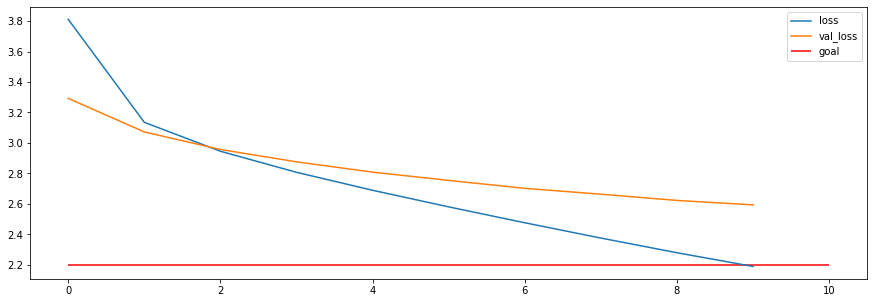

In [ ]:
#그래프 시각화
plt.figure(figsize=(15,5)) 
plt.plot(history_1.history['loss'], label='loss') 
plt.plot(history_1.history['val_loss'], label='val_loss') 
plt.hlines(2.2,0,10, color="red", label='goal')
plt.legend() 
plt.show()

1) 데이터 정제시 ' 제외하고 다시 학습시켜보니,
- loss, val_loss 값 모두 첫번째와 비슷하게 3.8 -> 2.1 (이전 : 3.7 -> 2.1 ), val_loss는 3.2 -> 2.5 (이전 : 3.2 ->2.6)감소되는 추세를 보였다.   
- `'`를 제외한 결과가 특별히 다르지 않았으며 단어별 정확한 학습을 시키기 위해 앞으로 2) ~ 추가) 까지 진행할 때도 `'`를 제외하고 데이터 처리를 해보도록 하자!

---

### 2) embedding size 증가하여 돌려보기  
- 기존 embedding_size = 256에서 512 로 2배 늘림

In [ ]:
embedding_size = 512
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [ ]:
for src_enc_train, dec_train in dataset.take(1): break

model(src_enc_train)

<tf.Tensor: shape=(256, 13, 42001), dtype=float32, numpy=
array([[[ 6.95777708e-05, -7.49619867e-05, -1.05386134e-04, ...,
          1.18071475e-04, -2.03238058e-04,  1.57719842e-04],
        [ 1.48362320e-04, -4.31669650e-05, -2.83305126e-04, ...,
          1.99377087e-06, -4.02617734e-04,  4.52123932e-04],
        [ 1.71986117e-04,  2.89765303e-04, -2.89339601e-04, ...,
         -1.66553058e-04, -3.38949496e-04,  3.18485749e-04],
        ...,
        [ 5.08209981e-04,  1.10813518e-04,  5.12705068e-04, ...,
         -5.10956743e-04, -9.64837498e-04,  6.61838218e-04],
        [ 3.40440398e-04,  2.36203428e-04,  5.49868157e-04, ...,
         -4.10400884e-04, -1.03054754e-03,  8.71616707e-04],
        [ 4.77154477e-04,  2.13364910e-04,  6.15742872e-04, ...,
         -4.36709350e-04, -8.44056834e-04,  8.42386391e-04]],

       [[ 6.95777708e-05, -7.49619867e-05, -1.05386134e-04, ...,
          1.18071475e-04, -2.03238058e-04,  1.57719842e-04],
        [-5.57886888e-05, -9.48375382e-05, -2

In [ ]:
#모델 서머리!
model.summary()

Model: "text_generator_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     multiple                  21504512  
                                                                 
 lstm_10 (LSTM)              multiple                  6295552   
                                                                 
 lstm_11 (LSTM)              multiple                  8392704   
                                                                 
 dense_5 (Dense)             multiple                  43051025  
                                                                 
Total params: 79,243,793
Trainable params: 79,243,793
Non-trainable params: 0
_________________________________________________________________


**Total params: 67,442,961 -> 79,243,793**  
우선 total para~의 값이 약 12백만개 증가한 것을 확인했다.  
숫자가 증가한만큼 loss값이 감소해주길 기대하며 학습을 시켜보자!

In [ ]:
#모델 학습시키기_재도전 2번째!
optimizer = tf.keras.optimizers.Adam()
#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
history_2 = model.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

Epoch 1/10
504/504 [==============================] - 109s 210ms/step - loss: 3.7499 - val_loss: 3.2982
Epoch 2/10
504/504 [==============================] - 105s 208ms/step - loss: 3.1347 - val_loss: 3.0710
Epoch 3/10
504/504 [==============================] - 105s 208ms/step - loss: 2.9436 - val_loss: 2.9633
Epoch 4/10
504/504 [==============================] - 105s 208ms/step - loss: 2.8118 - val_loss: 2.8823
Epoch 5/10
504/504 [==============================] - 105s 208ms/step - loss: 2.6984 - val_loss: 2.8213
Epoch 6/10
504/504 [==============================] - 105s 208ms/step - loss: 2.5950 - val_loss: 2.7689
Epoch 7/10
504/504 [==============================] - 105s 208ms/step - loss: 2.4977 - val_loss: 2.7223
Epoch 8/10
504/504 [==============================] - 105s 208ms/step - loss: 2.4057 - val_loss: 2.6845
Epoch 9/10
504/504 [==============================] - 105s 208ms/step - loss: 2.3180 - val_loss: 2.6512
Epoch 10/10
504/504 [==============================] - 105s 208m

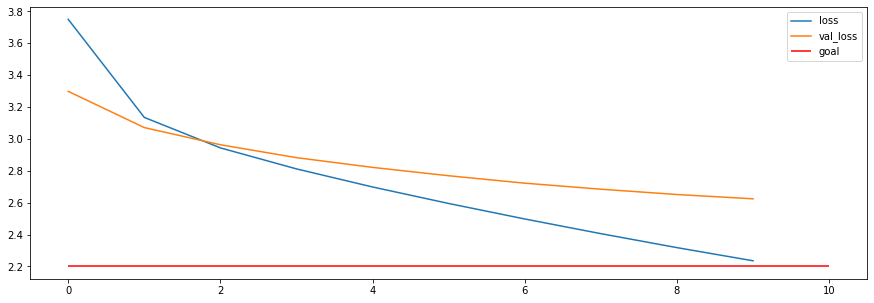

In [ ]:
#그래프 시각화
plt.figure(figsize=(15,5)) 
plt.plot(history_2.history['loss'], label='loss') 
plt.plot(history_2.history['val_loss'], label='val_loss') 
plt.hlines(2.2,0,10, color="red", label='goal')
plt.legend() 
plt.show()

띠로리.... 기대와 다르게 오히려 1,2째보다 못한 loss 값을 출력했다.... 주어진 값들에 비해 embedding size가 커서 모델이 학습을 잘하지 못한 모습인듯하다.  

그럼 embedding size를 256으로 고정하고 hidden layer를 증가시켜 다시 학습시켜보자.

---

### 3) hidden layer 증가하여 돌려보기  
- 기존 1024 -> 2048

In [ ]:
embedding_size = 256
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [ ]:
for src_enc_train, dec_train in dataset.take(1): break

model(src_enc_train)

<tf.Tensor: shape=(256, 13, 42001), dtype=float32, numpy=
array([[[ 3.43971951e-05, -3.64516927e-05,  1.22247307e-04, ...,
         -2.51088954e-06,  6.31559524e-05,  9.30493479e-05],
        [ 3.54978656e-05, -1.96789842e-05,  1.73105640e-04, ...,
          1.70215790e-04,  1.36425602e-04,  6.84368206e-05],
        [ 5.65494993e-05,  1.06066480e-04,  2.38032953e-04, ...,
          2.28866804e-04,  1.91272382e-04, -3.04550067e-05],
        ...,
        [-8.80102525e-05, -4.90243838e-05, -3.20960127e-04, ...,
         -3.73417482e-04, -1.28214146e-04, -4.59067058e-04],
        [ 1.07719403e-04, -4.67447826e-05, -1.31436376e-04, ...,
         -3.59150843e-04, -6.61479426e-05, -7.06114166e-04],
        [ 1.14205490e-04, -2.19526355e-05, -1.48702757e-05, ...,
         -2.37144093e-04, -1.37515293e-04, -8.02792551e-04]],

       [[ 3.43971951e-05, -3.64516927e-05,  1.22247307e-04, ...,
         -2.51088954e-06,  6.31559524e-05,  9.30493479e-05],
        [ 4.00869394e-05, -1.79380761e-04,  1

In [ ]:
#모델 서머리!
model.summary()

Model: "text_generator_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     multiple                  10752256  
                                                                 
 lstm_12 (LSTM)              multiple                  18882560  
                                                                 
 lstm_13 (LSTM)              multiple                  33562624  
                                                                 
 dense_6 (Dense)             multiple                  86060049  
                                                                 
Total params: 149,257,489
Trainable params: 149,257,489
Non-trainable params: 0
_________________________________________________________________


**Total params: 67,442,961 -> 149,257,489**
파라미터가 약 2배 이상 증가하였다.   
embedding size를 증가했던것보다 hidden size를 증가한게 더 효과가 좋은 것 같다.   

적절한 embedding size에서 더 자세히 뜯어보며 분류하니 확실히 좋은 값이 나오지 않을까 생각이 드는데 과연 결과는 어떻게 될지 궁금하다.

In [ ]:
#모델 학습시키기_재도전 3번째 
optimizer = tf.keras.optimizers.Adam()
#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
history_3 = model.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

Epoch 1/10
504/504 [==============================] - 223s 437ms/step - loss: 3.4329 - val_loss: 3.1132
Epoch 2/10
504/504 [==============================] - 220s 436ms/step - loss: 2.9698 - val_loss: 2.9410
Epoch 3/10
504/504 [==============================] - 220s 436ms/step - loss: 2.7759 - val_loss: 2.8300
Epoch 4/10
504/504 [==============================] - 220s 436ms/step - loss: 2.6069 - val_loss: 2.7421
Epoch 5/10
504/504 [==============================] - 220s 436ms/step - loss: 2.4535 - val_loss: 2.6825
Epoch 6/10
504/504 [==============================] - 220s 436ms/step - loss: 2.3144 - val_loss: 2.6248
Epoch 7/10
504/504 [==============================] - 220s 436ms/step - loss: 2.1883 - val_loss: 2.5828
Epoch 8/10
504/504 [==============================] - 220s 436ms/step - loss: 2.0719 - val_loss: 2.5479
Epoch 9/10
504/504 [==============================] - 220s 436ms/step - loss: 1.9636 - val_loss: 2.5207
Epoch 10/10
504/504 [==============================] - 220s 436m

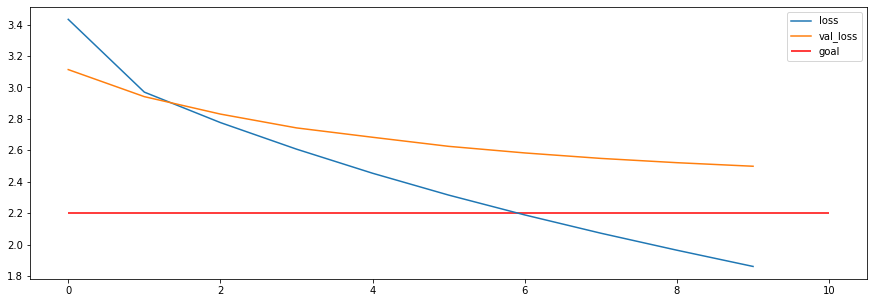

In [ ]:
#그래프 시각화
plt.figure(figsize=(15,5)) 
plt.plot(history_3.history['loss'], label='loss') 
plt.plot(history_3.history['val_loss'], label='val_loss') 
plt.hlines(2.2,0,10, color="red", label='goal')
plt.legend() 
plt.show()

그래도 loss 값은 1.8까지 내려가 상당히 줄어든 모습이다. 확실히 hidden layer를 올려서 자세히 보니 더 강하게 학습을 한것같다.  
그래도 val_loss는 2.4에서 머무는데,,,, 2.2는 도달할 수 없는 통곡의 벽인가.......... 후,,.,.,.,.,.,  


---

### 3-1) embedding & hidden layer 증가 콤보!

- 혹시 모르니 둘다 2배씩 증가시켜서 한번 돌려보자!  
- embedding_size : 256 -> 512 
- hidden layer :  1024 -> 2048

In [ ]:
embedding_size = 512
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [ ]:
for src_enc_train, dec_train in dataset.take(1): break

model(src_enc_train)

<tf.Tensor: shape=(256, 13, 42001), dtype=float32, numpy=
array([[[ 3.84114137e-05, -9.34963173e-05,  5.82608709e-06, ...,
          8.22806760e-05,  1.13448907e-04,  1.29264226e-04],
        [ 5.65672126e-05, -8.47801566e-05,  1.32329253e-04, ...,
          1.42117773e-04,  3.06787580e-04,  1.86348785e-04],
        [ 1.32787909e-06, -5.57075145e-05,  1.36533679e-04, ...,
          3.57909652e-04,  2.33446321e-04,  3.33561708e-04],
        ...,
        [-1.20302640e-04,  7.63419317e-04,  7.02634628e-04, ...,
          1.34939619e-03, -1.66582220e-04,  3.08641233e-04],
        [-4.26808372e-04,  6.88918168e-04,  6.21374696e-04, ...,
          1.18735631e-03, -8.95213161e-05,  1.80879448e-04],
        [-6.89721375e-04,  6.14700315e-04,  5.27065189e-04, ...,
          9.82603757e-04,  1.25429442e-05,  5.28531127e-05]],

       [[ 3.84114137e-05, -9.34963173e-05,  5.82608709e-06, ...,
          8.22806760e-05,  1.13448907e-04,  1.29264226e-04],
        [ 3.33688338e-04, -1.87834230e-04, -1

In [ ]:
#모델 서머리!
model.summary()

Model: "text_generator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  21504512  
                                                                 
 lstm_2 (LSTM)               multiple                  20979712  
                                                                 
 lstm_3 (LSTM)               multiple                  33562624  
                                                                 
 dense_1 (Dense)             multiple                  86060049  
                                                                 
Total params: 162,106,897
Trainable params: 162,106,897
Non-trainable params: 0
_________________________________________________________________


**Total params: 149,257,489 -> 162,106,897**

토탈 파라미터가 약 2천만개 증가한 것을 알 수 있다... 이정도면 돼야하는거아닐까....

In [ ]:
#모델 학습시키기_재도전 3.1번째 
optimizer = tf.keras.optimizers.Adam()
#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
history_3_1 = model.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

Epoch 1/10
504/504 [==============================] - 228s 447ms/step - loss: 3.5333 - val_loss: 3.1278
Epoch 2/10
504/504 [==============================] - 224s 445ms/step - loss: 2.9802 - val_loss: 2.9448
Epoch 3/10
504/504 [==============================] - 224s 445ms/step - loss: 2.7755 - val_loss: 2.8267
Epoch 4/10
504/504 [==============================] - 224s 444ms/step - loss: 2.6066 - val_loss: 2.7417
Epoch 5/10
504/504 [==============================] - 224s 444ms/step - loss: 2.4531 - val_loss: 2.6700
Epoch 6/10
504/504 [==============================] - 224s 444ms/step - loss: 2.3079 - val_loss: 2.6125
Epoch 7/10
504/504 [==============================] - 224s 445ms/step - loss: 2.1707 - val_loss: 2.5663
Epoch 8/10
504/504 [==============================] - 224s 444ms/step - loss: 2.0426 - val_loss: 2.5242
Epoch 9/10
504/504 [==============================] - 224s 444ms/step - loss: 1.9222 - val_loss: 2.4927
Epoch 10/10
504/504 [==============================] - 224s 444m

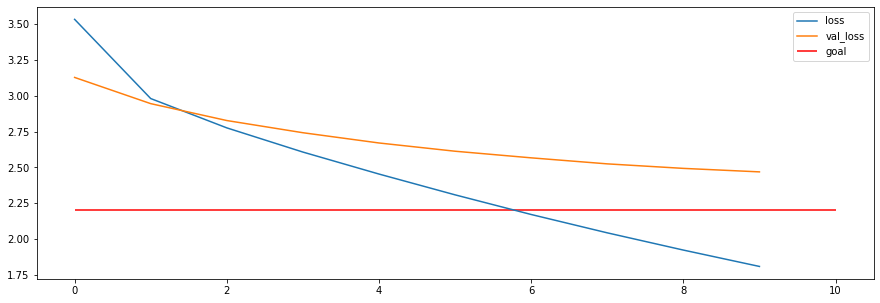

In [ ]:
#그래프 시각화
plt.figure(figsize=(15,5)) 
plt.plot(history_3_1.history['loss'], label='loss') 
plt.plot(history_3_1.history['val_loss'], label='val_loss') 
plt.hlines(2.2,0,10, color="red", label='goal')
plt.legend() 
plt.show()

아까와 같은 2.4쯤에서 val_loss가 낮아지지 않는다...  

흠....  그럼 진행하려고 했던 다른 것들을 변경해보자..

---

### 4) 다른 변경할 수 있을만한 것들 넣어서 돌려보기 

다른 값들 중 어떤 것을 변경해 볼 수 있을까 검색하다 overfitting을 방지하는 방법으로 **batch size를 변경해보는 것도 좋다**는 내용을 봤다.  

이전에 학습안정화가 안되던 때엔 batch size를 작게하는 것이 의외의 효과(부정확한 gradient가 계산되어 cost function 공간에서 오히려 local minimum을 뛰어넘음)를 불러왔지만,  
지금은 Adam 등의 기법을 사용하여 학습 안정화가 잘되는 경우가 많아 batch size를 키워도 local minima에 빠지지 않고 global로 잘 수렴한다고 한다.  

따라서 최근엔 batch size를 크게 넣을 수록 좋다는 내용을 확인하여 **batch size를 2배 증가**시켜보려고 한다.  

- batch size를 256 -> 512로 2배 증가 
- 앞서 진행한 결과 값이 좋아 hidden layer도 2048로 2배 증가

---

상기 방법으로 진행하려 했으나, batch도 그렇고 각각의 사이즈가 너무 커서그런지 코랩에서 오류가 난다...  

그래서 다른 대안으로 토크나이저에서 단어를 너무 자세하게 세분화 시켜서 경향을 내기 어려운걸까? 생각이 들어 단어 수를 줄여서 진행해보려고한다...

- num word : 42,000 -> 20,000 으로 감소 후 진행

In [ ]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=20000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)

    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[    2  1386    19 ...     0     0     0]
 [    2    33    45 ...     0     0     0]
 [    2     8    45 ...     3     0     0]
 ...
 [    2    30    19 ...     5 17293     3]
 [    2   346    19 ...   159     3     0]
 [    2    41   130 ...     0     0     0]] <keras_preprocessing.text.Tokenizer object at 0x7f3117a749d0>


In [ ]:
#tokenizer에 단어 사전이 어떻게 구축되었는지 한번 보자
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


20,001 ~ 40,000 까지의 단어가 없어져서 그런지 상위 10개의 단어는 변함이 없다.

In [ ]:
#생성된 텐서 데이터를 3번째 행, 15번째 열까지만 출력해보기(15이상은 짤랐으니까)
print(tensor[:3, :15])

[[   2 1386   19  364   10    6  610  659    3    0    0    0    0    0]
 [   2   33   45    7   93  321   10   36    3    0    0    0    0    0]
 [   2    8   45   61   17   40  245   28    7   10  199    3    0    0]]


In [ ]:

X = tensor[:, :-1]  
y = tensor[:, 1:]    

print(X[0])
print(y[0])

[   2 1386   19  364   10    6  610  659    3    0    0    0    0]
[1386   19  364   10    6  610  659    3    0    0    0    0    0]


In [ ]:
#trainning 데이터와 validation 데이터로 분리하기

enc_train, enc_val, dec_train, dec_val = train_test_split(X, y, test_size=0.2, random_state=50)

#잘 나눠졌는지 확인
print(enc_train.shape, dec_train.shape)
print(enc_val.shape, dec_val.shape)

(129040, 13) (129040, 13)
(32260, 13) (32260, 13)


In [ ]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 42,000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋 만들기
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) 
#drop_remainder= batch size에 도달하면 나머지 데이터는 버림 
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 13), dtype=tf.int32, name=None), TensorSpec(shape=(256, 13), dtype=tf.int32, name=None))>

In [ ]:
embedding_size = 512
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [ ]:
for src_enc_train, dec_train in dataset.take(1): break

model(src_enc_train)

<tf.Tensor: shape=(256, 13, 20001), dtype=float32, numpy=
array([[[ 1.19235818e-04,  1.01345162e-04,  2.00276409e-04, ...,
         -3.66671215e-04, -1.71832377e-04,  3.20997278e-05],
        [ 4.13316302e-04,  2.16611166e-04,  8.73483659e-05, ...,
         -3.22859065e-04, -4.24907330e-06,  4.19376709e-04],
        [ 6.04696164e-04,  5.71831246e-04, -1.58701951e-04, ...,
         -6.80299534e-04, -9.31715567e-06,  5.67031559e-04],
        ...,
        [ 1.52700942e-03,  7.36447866e-04,  7.06914579e-04, ...,
         -9.10080271e-04, -1.02184968e-04,  7.23354518e-04],
        [ 1.33512565e-03,  6.44317653e-04,  9.31752613e-04, ...,
         -1.07867748e-03, -4.32375877e-04,  5.28819161e-04],
        [ 9.77800926e-04,  8.03411647e-04,  1.10986596e-03, ...,
         -1.34775473e-03, -7.33503723e-04, -8.50686547e-07]],

       [[ 1.19235818e-04,  1.01345162e-04,  2.00276409e-04, ...,
         -3.66671215e-04, -1.71832377e-04,  3.20997278e-05],
        [-1.16434814e-04,  2.54857499e-04,  1

In [ ]:
#모델 서머리!
model.summary()

Model: "text_generator_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  10240512  
                                                                 
 lstm_4 (LSTM)               multiple                  20979712  
                                                                 
 lstm_5 (LSTM)               multiple                  33562624  
                                                                 
 dense_2 (Dense)             multiple                  40982049  
                                                                 
Total params: 105,764,897
Trainable params: 105,764,897
Non-trainable params: 0
_________________________________________________________________


단어집의 수가 적어져서 간편해졌는지 Total params가 162,106,897 -> 105,764,897 로 감소했다.

In [ ]:
#모델 학습시키기_재도전 4번째
optimizer = tf.keras.optimizers.Adam()
#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
history_4 = model.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

Epoch 1/10
504/504 [==============================] - 158s 307ms/step - loss: 3.4084 - val_loss: 3.0590
Epoch 2/10
504/504 [==============================] - 154s 306ms/step - loss: 2.9186 - val_loss: 2.8688
Epoch 3/10
504/504 [==============================] - 154s 306ms/step - loss: 2.7102 - val_loss: 2.7357
Epoch 4/10
504/504 [==============================] - 154s 306ms/step - loss: 2.5202 - val_loss: 2.6313
Epoch 5/10
504/504 [==============================] - 154s 306ms/step - loss: 2.3335 - val_loss: 2.5362
Epoch 6/10
504/504 [==============================] - 154s 305ms/step - loss: 2.1456 - val_loss: 2.4588
Epoch 7/10
504/504 [==============================] - 154s 306ms/step - loss: 1.9616 - val_loss: 2.3914
Epoch 8/10
504/504 [==============================] - 154s 306ms/step - loss: 1.7823 - val_loss: 2.3402
Epoch 9/10
504/504 [==============================] - 154s 306ms/step - loss: 1.6108 - val_loss: 2.2980
Epoch 10/10
504/504 [==============================] - 154s 306m

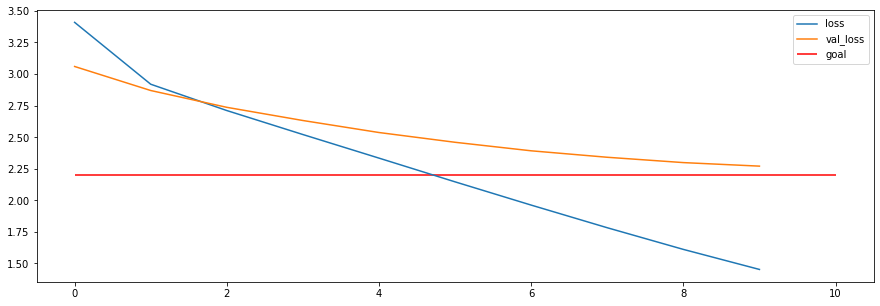

In [ ]:
#그래프 시각화
plt.figure(figsize=(15,5)) 
plt.plot(history_4.history['loss'], label='loss') 
plt.plot(history_4.history['val_loss'], label='val_loss') 
plt.hlines(2.20,0,10, color="red", label='goal')
plt.legend() 
plt.show()

ㅇㅏ..... 좁혀질듯 좁혀지지않는 저 거리.....  

그래도 loss 자체도 1.4대로 가장 낮고, val_loss가 꽤나 좁혀진 것으로 보아 **단어집모음에서 단어를 얼마나 깔끔하게 정리하는지**가 학습에 큰 도움이 되는 것 같다. 

또한 재미삼아 뽑아본 가사에서 ~ s 같은게 들어가지 않은 것으로 보아 '를 기준으로 자른것은 무의미한 것 같다는 생각이 든다.

그럼 마지막으로 `'`를 삭제하지 않고 의미 별로 모아서 한번 단어를 잘라보자.

---


### 5) ' 포함하고 embedding & hidden layer 2배 증가
- 데이터 정제 변경
- num word : 42,000 -> 20,000
- embedding_size : 256 -> 512 
- hidden layer :  1024 -> 2048

In [8]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-zA-Z?.!,¿']+", " ", sentence) 
    sentence = sentence.strip() 
    sentence = '<start> ' + sentence + ' <end>' 
    return sentence

In [9]:
# 정제된 문장을 담을 곳
corpus = []

for sentence in raw_corpus:
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)

    if preprocessed_sentence.count(' ') >= 14: continue

    corpus.append(preprocessed_sentence)

# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> build your dreams to the stars above <end>',
 '<start> but when you need someone to love <end>',
 "<start> and when there's no place for you to turn <end>",
 "<start> you'll follow your heart i know <end>",
 "<start> i've been through it all , for i'm an old hand <end>",
 "<start> and i'll understand if you go so <end>",
 '<start> make your mark for your friends to see <end>',
 '<start> but when you need more than company <end>',
 '<start> you give your soul so sweetly <end>',
 '<start> tonight the light of love is in your eyes <end>']

역시 there's, i'll, i'm 등 의미가 더 정확하게 뽑히는 것을 알 수 있다. 

In [10]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=20000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)

    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[    2  1423    17 ...     0     0     0]
 [    2    31    41 ...     0     0     0]
 [    2     8    41 ...     0     0     0]
 ...
 [    2    28    17 ...     4 18184     3]
 [    2   351    17 ...   159     3     0]
 [    2    37   131 ...     0     0     0]] <keras_preprocessing.text.Tokenizer object at 0x7f88df3ec410>


In [11]:
#tokenizer에 단어 사전이 어떻게 구축되었는지 한번 보자
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : the
6 : i
7 : you
8 : and
9 : a
10 : to


확실히 i의 순서가 낮아진 것을 보아 단어 사전은 의도한 대로 구축된 것 같다.

In [12]:
X = tensor[:, :-1]  
y = tensor[:, 1:]    

print(X[0])
print(y[0])

[   2 1423   17  378   10    5  628  684    3    0    0    0    0]
[1423   17  378   10    5  628  684    3    0    0    0    0    0]


In [15]:
enc_train, enc_val, dec_train, dec_val = train_test_split(X, y, test_size=0.2, random_state=10)

#잘 나눠졌는지 확인
print(enc_train.shape, dec_train.shape)
print(enc_val.shape, dec_val.shape)

(131640, 13) (131640, 13)
(32910, 13) (32910, 13)


In [16]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 42,000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋 만들기
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) 
#drop_remainder= batch size에 도달하면 나머지 데이터는 버림 
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 13), dtype=tf.int32, name=None), TensorSpec(shape=(256, 13), dtype=tf.int32, name=None))>

In [20]:
embedding_size = 512
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [21]:
for src_enc_train, dec_train in dataset.take(1): break

model(src_enc_train)

<tf.Tensor: shape=(256, 13, 20001), dtype=float32, numpy=
array([[[-1.43233410e-04, -1.35931768e-04, -8.84557303e-05, ...,
          3.99994344e-04, -1.13961745e-04, -2.26097574e-04],
        [-4.41243137e-05,  4.33140231e-05,  1.14767834e-04, ...,
          7.51445012e-04, -8.76506238e-05, -4.58382943e-04],
        [ 1.13305279e-04,  1.45594269e-04,  1.24603903e-04, ...,
          8.16217973e-04, -7.06700885e-05, -5.71363198e-04],
        ...,
        [-3.04013665e-04, -2.02951342e-04,  7.80078641e-04, ...,
         -6.32002659e-04, -1.09833688e-03, -1.60829839e-03],
        [-2.35595784e-04, -6.39248581e-04,  7.45243509e-04, ...,
         -7.08063832e-04, -1.26043148e-03, -1.64116337e-03],
        [-3.41792969e-04, -1.11595041e-03,  4.52456909e-04, ...,
         -9.58714227e-04, -1.22337532e-03, -1.68897735e-03]],

       [[-1.43233410e-04, -1.35931768e-04, -8.84557303e-05, ...,
          3.99994344e-04, -1.13961745e-04, -2.26097574e-04],
        [-4.41243137e-05,  4.33140231e-05,  1

In [22]:
#모델 서머리!
model.summary()

Model: "text_generator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  10240512  
                                                                 
 lstm_2 (LSTM)               multiple                  20979712  
                                                                 
 lstm_3 (LSTM)               multiple                  33562624  
                                                                 
 dense_1 (Dense)             multiple                  40982049  
                                                                 
Total params: 105,764,897
Trainable params: 105,764,897
Non-trainable params: 0
_________________________________________________________________


역시 layer에선 큰 변화를 주지 않아서 그런지 Total param은 105,764,897로 변함이 없다.

In [24]:
#모델 학습시키기_재도전 5번째...!
optimizer = tf.keras.optimizers.Adam()
#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
history_5 = model.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

Epoch 1/10
514/514 [==============================] - 160s 306ms/step - loss: 2.9765 - val_loss: 2.8899
Epoch 2/10
514/514 [==============================] - 157s 305ms/step - loss: 2.6919 - val_loss: 2.7149
Epoch 3/10
514/514 [==============================] - 157s 305ms/step - loss: 2.4126 - val_loss: 2.5772
Epoch 4/10
514/514 [==============================] - 157s 305ms/step - loss: 2.1370 - val_loss: 2.4779
Epoch 5/10
514/514 [==============================] - 157s 305ms/step - loss: 1.8858 - val_loss: 2.4105
Epoch 6/10
514/514 [==============================] - 157s 305ms/step - loss: 1.6647 - val_loss: 2.3644
Epoch 7/10
514/514 [==============================] - 157s 305ms/step - loss: 1.4749 - val_loss: 2.3412
Epoch 8/10
514/514 [==============================] - 157s 305ms/step - loss: 1.3184 - val_loss: 2.3333
Epoch 9/10
514/514 [==============================] - 157s 305ms/step - loss: 1.1956 - val_loss: 2.3428
Epoch 10/10
514/514 [==============================] - 157s 305m

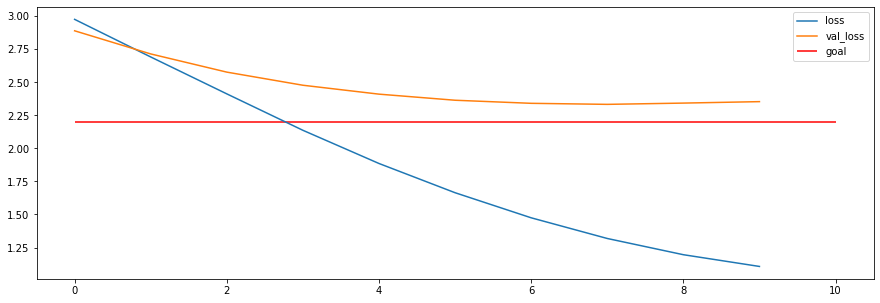

In [25]:
#그래프 시각화
plt.figure(figsize=(15,5)) 
plt.plot(history_5.history['loss'], label='loss') 
plt.plot(history_5.history['val_loss'], label='val_loss') 
plt.hlines(2.20,0,10, color="red", label='goal')
plt.legend() 
plt.show()

train loss는 1.1 까지 내려가며 확실히 학습이 잘된 것 같은데, val_loss는 2.3까지 밖에 내려가지 않는다... 왜때문이지??  
valiidation data 20%로 잘 부여해 준 것 같긴한데,, 쉽지 않다..  
다음엔 토큰을 15개 이상은 제외 시켰는데, 좀 더 학습량을 늘리기 위해 토큰양 17이상을 제외하는 걸로 바꿔서 진행해보려고 한다. 

### 6) 문장 제외 토큰 갯수 늘리기
- 15개 이상 삭제 -> 17개 이상 삭제   
(start, end 제외 15단어로 생각)

이걸로 어느정도의 학습량을 증가할 수 있을진 모르겠지만 우선 진행해보자. 

In [26]:
txt_file_path = '/content/drive/MyDrive/COLAB_data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담기
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Build your dreams to the stars above', 'But when you need someone to love', "Don't go to strangers, darling, come to me Play with fire till your fingers burn"]


In [27]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-zA-Z?.!,¿']+", " ", sentence) 
    sentence = sentence.strip() 
    sentence = '<start> ' + sentence + ' <end>' 
    return sentence

In [28]:
# 정제된 문장을 담을 곳
corpus = []

for sentence in raw_corpus:
    
    preprocessed_sentence = preprocess_sentence(sentence)

    if preprocessed_sentence.count(' ') >= 16: continue

    corpus.append(preprocessed_sentence)

#10개 확인
corpus[:10]

['<start> build your dreams to the stars above <end>',
 '<start> but when you need someone to love <end>',
 "<start> and when there's no place for you to turn <end>",
 "<start> you'll follow your heart i know <end>",
 "<start> i've been through it all , for i'm an old hand <end>",
 "<start> and i'll understand if you go so <end>",
 '<start> make your mark for your friends to see <end>',
 '<start> but when you need more than company <end>',
 '<start> you give your soul so sweetly <end>',
 '<start> tonight the light of love is in your eyes <end>']

In [29]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=20000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)

    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2 1420   18 ...    0    0    0]
 [   2   30   42 ...    0    0    0]
 [   2    8   42 ...    0    0    0]
 ...
 [   2   28   18 ...    3    0    0]
 [   2  343   18 ...    0    0    0]
 [   2   37  132 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f88dd89dc90>


In [30]:
#tokenizer에 단어 사전이 어떻게 구축되었는지 한번 보자
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : the
6 : i
7 : you
8 : and
9 : a
10 : to


In [31]:
X = tensor[:, :-1]  
y = tensor[:, 1:]    

print(X[0])
print(y[0])

[   2 1420   18  392   10    5  643  699    3    0    0    0    0    0
    0]
[1420   18  392   10    5  643  699    3    0    0    0    0    0    0
    0]


In [32]:
enc_train, enc_val, dec_train, dec_val = train_test_split(X, y, test_size=0.2, random_state=10)

#잘 나눠졌는지 확인
print(enc_train.shape, dec_train.shape)
print(enc_val.shape, dec_val.shape)

(139084, 15) (139084, 15)
(34771, 15) (34771, 15)


In [33]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 42,000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋 만들기
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) 
#drop_remainder= batch size에 도달하면 나머지 데이터는 버림 
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 15), dtype=tf.int32, name=None), TensorSpec(shape=(256, 15), dtype=tf.int32, name=None))>

In [34]:
embedding_size = 512
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [35]:
for src_enc_train, dec_train in dataset.take(1): break

model(src_enc_train)

<tf.Tensor: shape=(256, 15, 20001), dtype=float32, numpy=
array([[[-2.18610003e-04,  1.32109111e-04, -1.02970218e-04, ...,
         -5.68660971e-06,  2.44730327e-04, -7.16826835e-05],
        [-1.14732502e-04,  1.17803414e-04,  6.28373818e-05, ...,
          3.31839867e-04,  5.19757567e-04, -1.71868567e-04],
        [-3.35944642e-04, -1.92050647e-04,  9.26405701e-05, ...,
          5.73359313e-04,  6.63640792e-04, -1.31259061e-04],
        ...,
        [ 1.21421774e-03, -4.83805954e-04,  9.51139140e-04, ...,
          1.05055526e-03,  3.63089406e-04, -2.53003323e-04],
        [ 1.41768903e-03, -8.19977082e-04,  9.92167741e-04, ...,
          1.54535775e-03,  5.64692484e-04, -5.84479072e-04],
        [ 1.62727281e-03, -1.14102731e-03,  9.44383617e-04, ...,
          2.02808389e-03,  8.19512876e-04, -9.25715372e-04]],

       [[-2.18610003e-04,  1.32109111e-04, -1.02970218e-04, ...,
         -5.68660971e-06,  2.44730327e-04, -7.16826835e-05],
        [-6.46910339e-04,  9.67698506e-05, -3

In [36]:
#모델 서머리!
model.summary()

Model: "text_generator_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  10240512  
                                                                 
 lstm_4 (LSTM)               multiple                  20979712  
                                                                 
 lstm_5 (LSTM)               multiple                  33562624  
                                                                 
 dense_2 (Dense)             multiple                  40982049  
                                                                 
Total params: 105,764,897
Trainable params: 105,764,897
Non-trainable params: 0
_________________________________________________________________


음 토탈 파라미터의 값은 변함이 없다.

In [37]:
#모델 학습시키기_재도전 6번째...!
optimizer = tf.keras.optimizers.Adam()
#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
history_6 = model.fit(dataset, epochs=10, validation_data = (enc_val, dec_val))

Epoch 1/10
543/543 [==============================] - 191s 348ms/step - loss: 3.2549 - val_loss: 2.9325
Epoch 2/10
543/543 [==============================] - 189s 348ms/step - loss: 2.7977 - val_loss: 2.7426
Epoch 3/10
543/543 [==============================] - 189s 348ms/step - loss: 2.6253 - val_loss: 2.6237
Epoch 4/10
543/543 [==============================] - 189s 348ms/step - loss: 2.4813 - val_loss: 2.5301
Epoch 5/10
543/543 [==============================] - 189s 348ms/step - loss: 2.3444 - val_loss: 2.4480
Epoch 6/10
543/543 [==============================] - 189s 348ms/step - loss: 2.2050 - val_loss: 2.3755
Epoch 7/10
543/543 [==============================] - 189s 348ms/step - loss: 2.0641 - val_loss: 2.3126
Epoch 8/10
543/543 [==============================] - 189s 348ms/step - loss: 1.9222 - val_loss: 2.2562
Epoch 9/10
543/543 [==============================] - 189s 348ms/step - loss: 1.7816 - val_loss: 2.2110
Epoch 10/10
543/543 [==============================] - 189s 348m

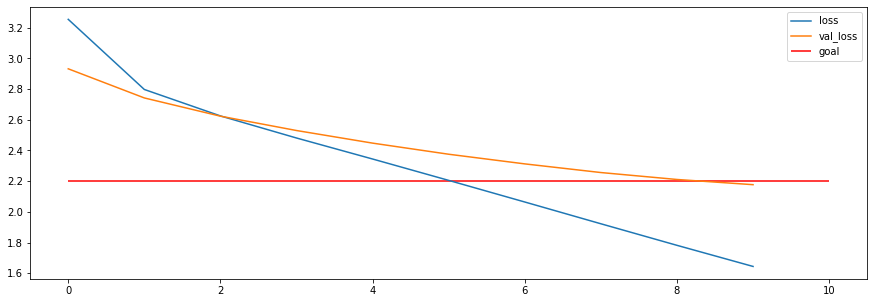

In [38]:
#그래프 시각화
plt.figure(figsize=(15,5)) 
plt.plot(history_6.history['loss'], label='loss') 
plt.plot(history_6.history['val_loss'], label='val_loss') 
plt.hlines(2.20,0,10, color="red", label='goal')
plt.legend() 
plt.show()

핳씌..... 드디어....!!!! 감격스러운 순간이네요...!!!ㅠㅠ   

이제 드디어 가사를 뽑아내 봅시다!!!!!

## 인공지능을 통해 가사 뽑아내기
--- 

In [39]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]


    while True:
        predict = model(test_tensor) 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""

    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [40]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love the way you lie <end> '

호오...

In [41]:
generate_text(model, tokenizer, init_sentence="<start> i hate", max_len=20)

'<start> i hate to see her die <end> '

In [42]:
generate_text(model, tokenizer, init_sentence="<start> i live", max_len=20)

'<start> i live for the funk ill die for the funk <end> '

너... 좀 멋진 아이구나?ㅎㅎㅎ

In [43]:
generate_text(model, tokenizer, init_sentence="<start> i like", max_len=20)

'<start> i like it , like it , like it <end> '

In [44]:
generate_text(model, tokenizer, init_sentence="<start> he was", max_len=20)

'<start> he was just a little trapeze <end> '

In [45]:
generate_text(model, tokenizer, init_sentence="<start> she was", max_len=20)

'<start> she was with me before i was just a little while <end> '

In [49]:
generate_text(model, tokenizer, init_sentence="<start> my little", max_len=20)

'<start> my little sister , she s in my heart <end> '

In [50]:
generate_text(model, tokenizer, init_sentence="<start> my heart", max_len=20)

'<start> my heart is so thick and my hair is so grateful <end> '

## 회고
- 우선 제한 환경에서 하나의 문제를 해결하고자 다양한 방법을 생각하고 스스로 가설을 세워 진행해보는 과정이 조금은 고통스럽기도 했지만, 계속 단계별로 어떤 걸 고칠 수 있을까 생각하면서 코드를 더 잘 이해하게 된 것 같다. 
- 그리고 확실히 여유를 가지고 진행을 하다보니 그냥 코드를 복붙하는게 아니라 '저 코드가 무슨 역할을 하길래 왜 이 상황에서 넣었을까?', ''이 부분에 이런 것을 추가하고 싶은데 그럼 어느 부분에 넣어야 내가 원하는 모양대로 뽑아 낼 수 있을까?' 생각하면서 진행을 하게 되어 코드를 짜는 사람으로 한발짝 나아간 기분이 들었다. 
- 임베딩, 히든레이어 등을 집중해서 이해하기도 좋았다. 
- 코드 관련해서 물어봤을 때 들었던 얘기가 "한번 해보세요~" 였는데, 이전 분야에선 하나의 가설을 확인하기 위해 다른 부서로 요청하고 많은 시간을 들여서 해서 바로바로 시험해 보는 상황이 이해가 되지 않았다. 하지만 이번 경험을 통해 진짜 한번 해보는게 제일 좋다라는 걸 느꼈다. 그리고 몇 분 ~ 몇 시간 이내로 스스로 가설을 세워 확인하는 과정이 재밌고 흥미로웠다.  
- 저번 Ex 진행시 시각화를 하지 못한게 아쉬워 이번엔 시각화 함수를 찾아서 넣었는데, 확실히 숫자로만 줄어드는 것을 보는 것 보다 시각화를 하니 진행된 내용을 한눈에 이해하기 좋았다. 왜 다들 시각화를 하고 정리하려했는지 이해가됐다. 이후에 진행할 때도 적절한 시각화 함수를 사용하여 나와 상대방에게 한눈에 이해하기 좋게 만들기위해 노력해야겠다. 
- 전처리의 중요성을 알게되었다. 같은 코드를 사용해 쓰더라도 내가 데이터를 어떻게 넣어주는지가 생각보다 훨씬 중요하다는 것을 알게되었다. 그동안 주어진 자료를 믿고 바로 갖다쓰고 했었는데, 앞으로는 주어진 자료를 어떻게하면 좋은 결과를 이끌어낼 수 있을지 생각하고 처리하는데 더 집중해야겠다.  
이번에 느꼈던 건 `'` 포함하고 안하고의 결과값이 너무 달랐고, 토큰 길이 15 -> 17로 바꿨을 때에도 결과값이 너무 달랐다는 것이다. 길게 했을 땐, i like it, i like it, 등 반복되는 문장이 들어가서 그런지 단순 반복문이 나왔다는 것이다. 

- 그리고 뭣보다... **이번것도 너무 재밌다**!!!! 흐흐흐 인공지능을 통해 가사를 뽑아내다니.... 것도 생각보다 결과값이 있어보이고요?? 진짜 컴퓨터도 창작활동을 할 수 있는 세상이 올지도 모른다! 두근... 

- 그리고.... 안될 것 같다 싶으면... 더 매달리고 한번 더 돌리는 것 보다.... 걍 코드를 고치는게 더 빨리 해결하는 방법이다....